In [2]:
from qiskit import QuantumCircuit,transpile
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM,optimize_single_qubit_gates
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,QRewindingRC_Single_Use_QPU
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "287K1FQqLZ9JU+FxO6C4l6TXENKy0SFUO8h5P4po3DIGZeGb5qhzo4AAi21PIAqd"

#SHOTS = 8000

backend = IQMProvider(server_url, token=api_token).get_backend()

ImportError: cannot import name 'QRewindingRC_Single_Use_QPU' from 'src.rewinding' (/home/thomascope/Python_Proj/Experiment/src/rewinding.py)

## The "Default" unitary we were considering : 0^th Order Ising ##

This is the unitary we discussed, with no optimisation. 

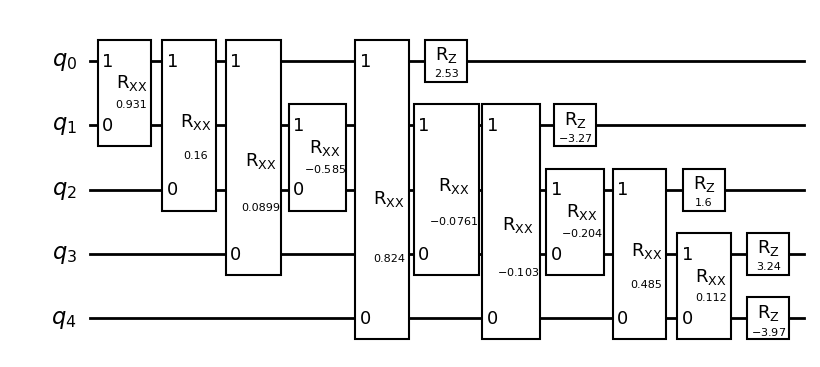

In [2]:
from src.circuits import ising_circuit

ising = ising_circuit(nqubits=5, rseed=9369)

ising.draw('mpl')

ising_circuit(nqubits=5, rseed=9369).draw('mpl')

ising.draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit.svg',
    # scale=0.5,
    style='bw', # iqx bw
)

As we discussed, one may have to cut down the connectivity, to reduce the number of 2 qubit gates. Some possibilities are given here. Note that we expect reduced performance with less connectivity.

nearest neighbour (non circular)


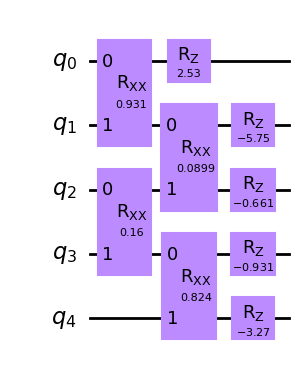

In [35]:
print('nearest neighbour (non circular)')
ising_circuit(nqubits=5, rseed=9369,mode='nn').draw('mpl')

ladder


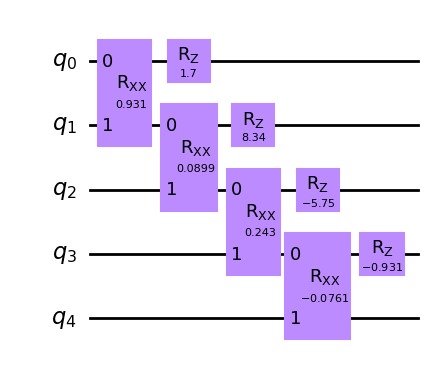

In [4]:
print('ladder')
ising_circuit(nqubits=5, rseed=9369,mode='ladder').draw('mpl')

 up-down ladder


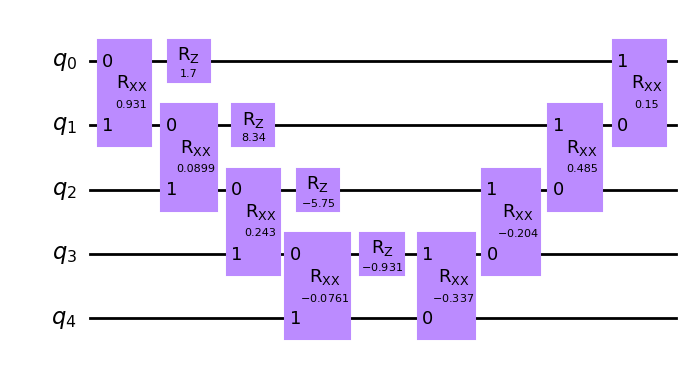

In [5]:
print(' up-down ladder')
ising_circuit(nqubits=5, rseed=9369,mode='up_down_ladder').draw('mpl')

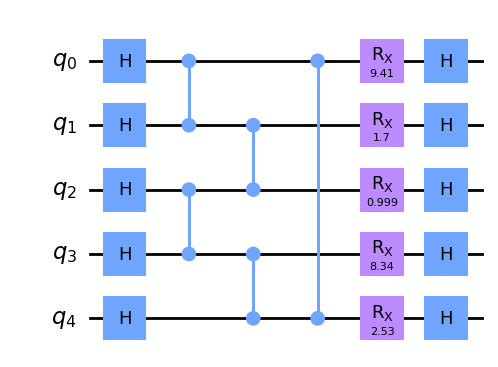

In [5]:
from src.circuits import native_circuit

native_circuit(nqubits=5, mode='nnc',rseed=9369).draw('mpl')

## Swapping the Role of Z and X : Method 1

Since ZZ gates are native, it makes sense to swap the role of X and Z in the Ising. Whilst in principle, this is the same model, the fact we begin in the all 0 state means some adjustments are necessary. One possibility is to swap the order of the 1 and 2 qubit gates.


all to all connected


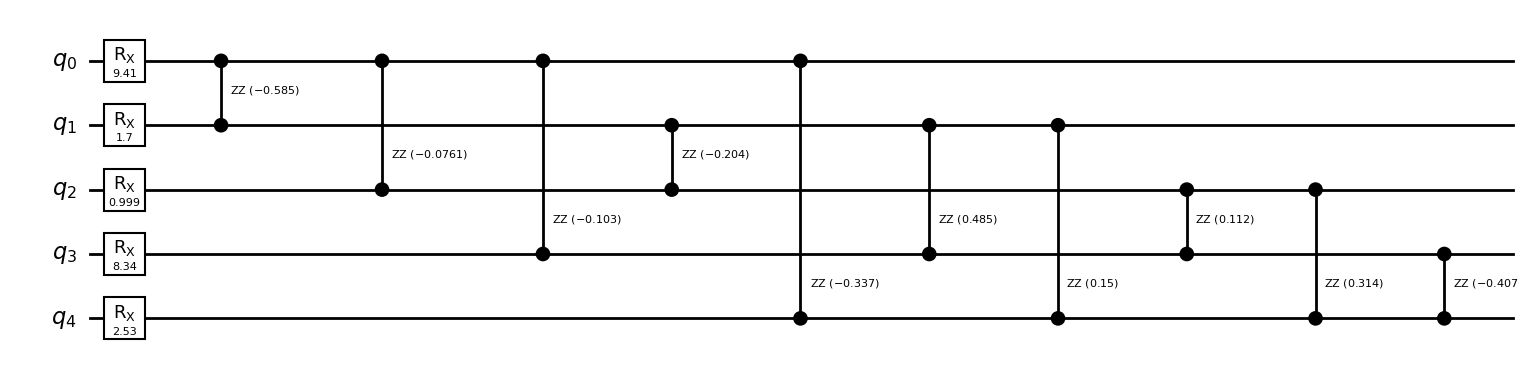

In [6]:
from src.circuits import ising_circuit_natural


print('all to all connected')
ising_circuit_natural(nqubits=5, rseed=9369).draw('mpl')

ising_circuit_natural(nqubits=5, rseed=9369).draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit_natural.svg',
    # scale=0.5,
    style='bw', # iqx bw
)

nearest neighbour


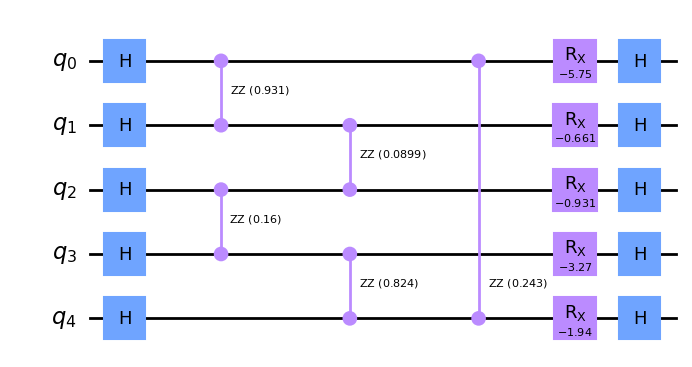

In [37]:
print('nearest neighbour')
ising_circuit_naturalH(nqubits=5, rseed=9369,mode='nnc').draw('mpl')

ladder


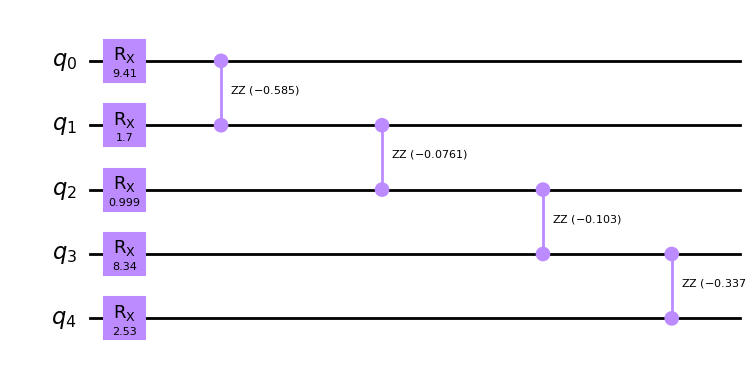

In [8]:
print('ladder')
ising_circuit_natural(nqubits=5, rseed=9369,mode='up_ladder').draw('mpl')

up_ down_ladder
For this connection, there is not really a good way to directly translate it - we have to simply "add" extra 1 qubit rotations.


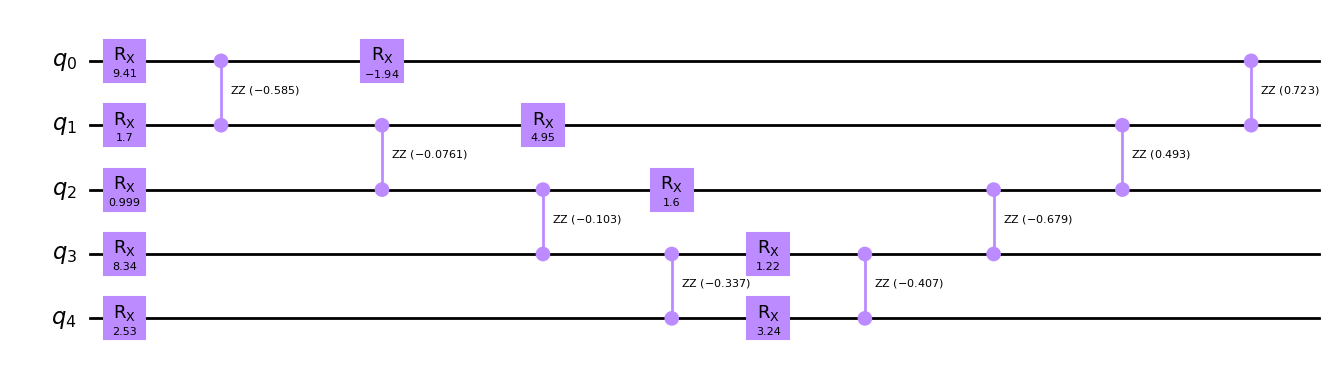

In [9]:
print('up_ down_ladder')
print('For this connection, there is not really a good way to directly translate it - we have to simply "add" extra 1 qubit rotations.')
ising_circuit_natural(nqubits=5, rseed=9369,mode='up_down_ladder').draw('mpl')


## Swapping the Role of Z and X : Method 2 ##

A simpler way to convert the results of first model to the native hardware is to simply sandwich it with Hadamards: This avoids the issue of swapping the order of the 1 and 2 qubit operations.

In [20]:
from src.circuits import ising_circuit_naturalH

print('We can now call all the options available to the default: e.g. all to all connectivity')
ising_circuit_naturalH(nqubits=5, rseed=9369).draw('mpl')

ising_circuit_naturalH(nqubits=5, rseed=9369,mode='nnc').draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit_natural.svg',
    # scale=0.5,
    style='bw', # iqx bw
)

circ=ising_circuit_naturalH(nqubits=5, rseed=9369,mode='nnc')
from src.circuits import ising_circuit
circ2=ising_circuit(nqubits=5, rseed=9369,mode='nn')

We can now call all the options available to the default: e.g. all to all connectivity


In [11]:
backend.coupling_map

In [23]:

transpiled = transpile(circ, backend, basis_gates=['r', 'cz'], coupling_map=backend.coupling_map, optimization_level=3)
transpiled = optimize_single_qubit_gates(transpiled)
transpiled_matched_to_backend = QuantumCircuit(backend.num_qubits, transpiled.num_clbits)
transpiled_matched_to_backend = transpiled_matched_to_backend.compose(transpiled, qubits=list(range(transpiled.num_qubits)), clbits=list(range(transpiled.num_clbits)))

In [33]:

transpiled = transpile(circ.compose(circ), backend, basis_gates=['r', 'cz'], coupling_map=backend.coupling_map, optimization_level=3)
transpiled = optimize_single_qubit_gates(transpiled)
transpiled_matched_to_backend = QuantumCircuit(backend.num_qubits, transpiled.num_clbits)
transpiled_matched_to_backend = transpiled_matched_to_backend.compose(transpiled, qubits=list(range(transpiled.num_qubits)), clbits=list(range(transpiled.num_clbits)))
trans_z=transpiled_matched_to_backend
print('without Hadamard',dict(trans_z.count_ops()))

transpiled = transpile(circ2.compose(circ2), backend, basis_gates=['r', 'cz'], coupling_map=backend.coupling_map, optimization_level=3)
transpiled = optimize_single_qubit_gates(transpiled)
transpiled_matched_to_backend = QuantumCircuit(backend.num_qubits, transpiled.num_clbits)
transpiled_matched_to_backend = transpiled_matched_to_backend.compose(transpiled, qubits=list(range(transpiled.num_qubits)), clbits=list(range(transpiled.num_clbits)))
trans_x=transpiled_matched_to_backend
print('with Hadamard',dict(trans_x.count_ops()))

without Hadamard {'r': 38, 'cz': 23}
with Hadamard {'r': 36, 'cz': 16}


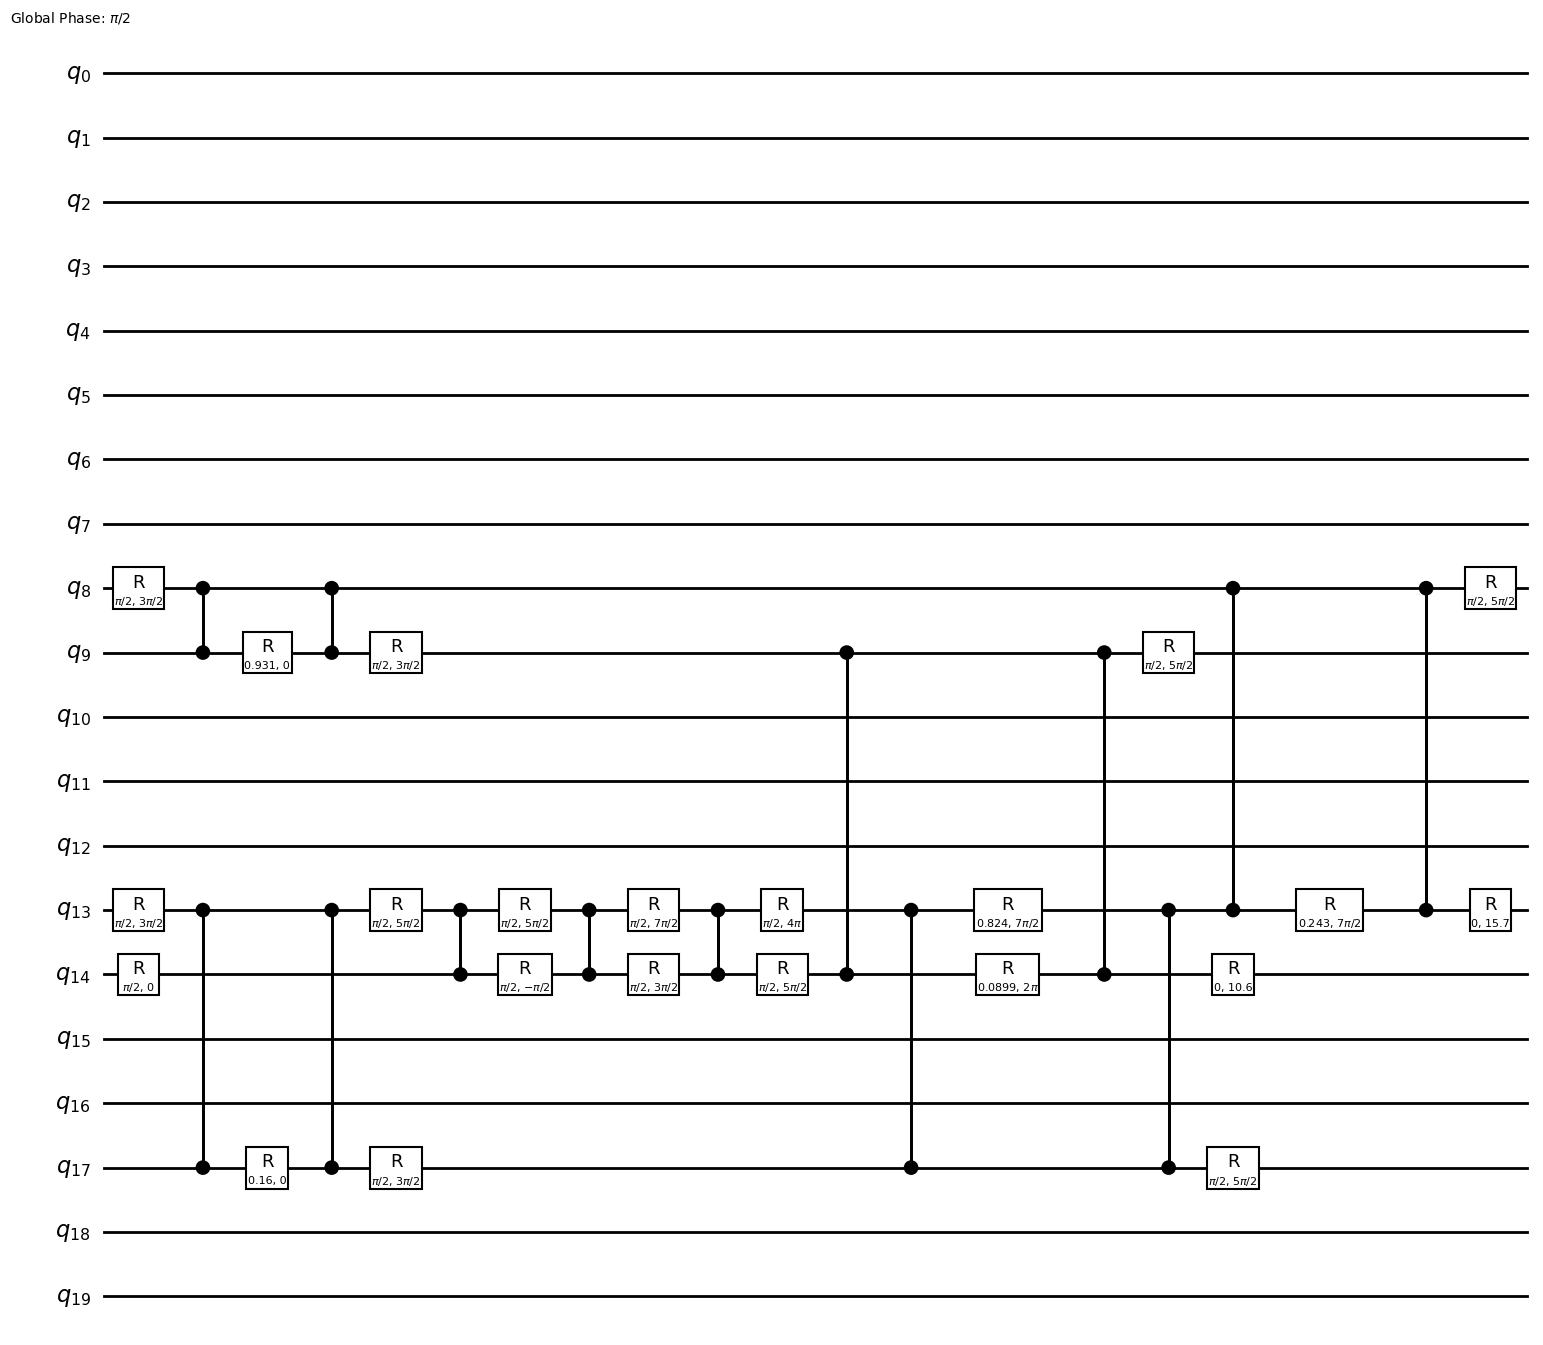

In [24]:
transpiled_matched_to_backend.draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit_natural.svg',
    # scale=0.5,
    style='bw', # iqx bw
)

In [11]:
rnn = QRewindingStatevectorRC(restarting=False, lookback=10, qctype='ising')

Aer
AerSimulator('aer_simulator')


In [12]:
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn.run(data)

In [13]:
rnn.unistep.draw()

┌───────────────┐┌────────────────┐┌────────────────┐                 »
q_0: ┤1              ├┤1               ├┤1               ├─────────────────»
     │  Rxx(0.27392) ││                ││                │┌───────────────┐»
q_1: ┤0              ├┤  Rxx(-0.46043) ├┤                ├┤1              ├»
     └───────────────┘│                ││  Rxx(-0.91805) ││  Rxx(0.82551) │»
q_2: ─────────────────┤0               ├┤                ├┤0              ├»
                      └────────────────┘│                │└───────────────┘»
q_3: ───────────────────────────────────┤0               ├─────────────────»
                                        └────────────────┘                 »
q_4: ──────────────────────────────────────────────────────────────────────»
                                                                           »
«     ┌────────────────┐  ┌────────────┐                                   »
«q_0: ┤1               ├──┤ Rz(6.3654) ├───────────────────────────────────»
«     │                │┌─┴────────────┴┐┌───────────────┐  ┌────────────┐ »
«q_1: ┤                ├┤1              ├┤1              ├──┤ Rz(0.9725) ├─»
«     │                ││               ││               │┌─┴────────────┴┐»
«q_2: ┤  Rxx(-0.96694) ├┤  Rxx(0.21327) ├┤               ├┤1              ├»
«     │                ││               ││  Rxx(0.45899) ││  Rxx(0.87014) │»
«q_3: ┤                ├┤0              ├┤               ├┤0              ├»
«     │                │└───────────────┘│               │└───────────────┘»
«q_4: ┤0               ├─────────────────┤0              ├─────────────────»
«     └────────────────┘                 └───────────────┘                 »
«                                                      
«q_0: ─────────────────────────────────────────────────
«                                                      
«q_1: ─────────────────────────────────────────────────
«     ┌───────────────┐ ┌─────────────┐                
«q_2: ┤1              ├─┤ Rz(-9.8452) ├────────────────
«     │               │┌┴─────────────┴┐┌─────────────┐
«q_3: ┤  Rxx(0.63171) ├┤1              ├┤ Rz(-9.2283) ├
«     │               ││  Rxx(0.71481) │└┬────────────┤
«q_4: ┤0              ├┤0              ├─┤ Rz(4.6931) ├
«     └───────────────┘└───────────────┘ └────────────┘

In [14]:
rnn_nat = QRewindingStatevectorRC(restarting=False, lookback=10, qctype='ising_natural')
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_nat.run(data)
rnn_nat.unistep.draw()

Aer
AerSimulator('aer_simulator')


┌────────────┐                                                        »
q_0: ─┤ Rx(2.8392) ├─■─────────────■─────────────■──────────────────────────»
     ┌┴────────────┤ │ZZ(0.82551)  │             │                          »
q_1: ┤ Rx(-4.5043) ├─■─────────────┼─────────────┼─────────────■────────────»
     ├─────────────┤               │ZZ(0.21327)  │             │ZZ(0.87014) »
q_2: ┤ Rx(-9.0805) ├───────────────■─────────────┼─────────────■────────────»
     ├─────────────┤                             │ZZ(0.45899)               »
q_3: ┤ Rx(-9.5694) ├─────────────────────────────■──────────────────────────»
     └┬────────────┤                                                        »
q_4: ─┤ Rx(6.3654) ├────────────────────────────────────────────────────────»
      └────────────┘                                                        »
«                                                                             »
«q_0: ─■──────────────────────────────────────────────────────────────────────»
«      │                                                                      »
«q_1: ─┼─────────────■─────────────■──────────────────────────────────────────»
«      │             │             │                                          »
«q_2: ─┼─────────────┼─────────────┼──────────────■─────────────■─────────────»
«      │             │ZZ(0.63171)  │              │ZZ(0.71481)  │             »
«q_3: ─┼─────────────■─────────────┼──────────────■─────────────┼─────────────»
«      │ZZ(0.08725)                │ZZ(-0.99452)                │ZZ(-0.93283) »
«q_4: ─■───────────────────────────■────────────────────────────■─────────────»
«                                                                             »
«                   
«q_0: ──────────────
«                   
«q_1: ──────────────
«                   
«q_2: ──────────────
«                   
«q_3: ─■────────────
«      │ZZ(0.45931) 
«q_4: ─■────────────
«

In [15]:
rnn_h = QRewindingStatevectorRC(restarting=False, lookback=10, qctype='ising_hadamard')
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h.run(data)
rnn_h.unistep.draw()

Aer
AerSimulator('aer_simulator')


┌───┐                                                          »
q_0: ┤ H ├─■─────────────■──────────────■───────────────────────────»
     ├───┤ │ZZ(0.27392)  │              │                           »
q_1: ┤ H ├─■─────────────┼──────────────┼──────────────■────────────»
     ├───┤               │ZZ(-0.46043)  │              │ZZ(0.82551) »
q_2: ┤ H ├───────────────■──────────────┼──────────────■────────────»
     ├───┤                              │ZZ(-0.91805)               »
q_3: ┤ H ├──────────────────────────────■───────────────────────────»
     ├───┤                                                          »
q_4: ┤ H ├──────────────────────────────────────────────────────────»
     └───┘                                                          »
«                    ┌────────────┐    ┌───┐                                 »
«q_0: ─■─────────────┤ Rx(6.3654) ├────┤ H ├─────────────────────────────────»
«      │             └────────────┘    └───┘     ┌────────────┐    ┌───┐     »
«q_1: ─┼──────────────■─────────────■────────────┤ Rx(0.9725) ├────┤ H ├─────»
«      │              │             │            └────────────┘    └───┘     »
«q_2: ─┼──────────────┼─────────────┼─────────────■─────────────■────────────»
«      │              │ZZ(0.21327)  │             │ZZ(0.87014)  │            »
«q_3: ─┼──────────────■─────────────┼─────────────■─────────────┼────────────»
«      │ZZ(-0.96694)                │ZZ(0.45899)                │ZZ(0.63171) »
«q_4: ─■────────────────────────────■───────────────────────────■────────────»
«                                                                            »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«     ┌─────────────┐     ┌───┐          
«q_2: ┤ Rx(-9.8452) ├─────┤ H ├──────────
«     └─────────────┘┌────┴───┴────┐┌───┐
«q_3: ──■────────────┤ Rx(-9.2283) ├┤ H ├
«       │ZZ(0.71481) └┬────────────┤├───┤
«q_4: ──■─────────────┤ Rx(4.6931) ├┤ H ├
«                     └────────────┘└───┘

In [16]:
print(rnn_h.__dict__.keys())

dict_keys(['rseed', 'log', 'washout', 'washout_eff', 'add_x_as_feature', 'nyfuture', 'delete_future_y', 'fitter', 'regression_model', 'regression_alpha', 'regression_l1', 'poly_degree', 'mse_val', 'mse_train', 'mape_val', 'mape_train', 'nrmse_val', 'nrmse_train', 'traintime', 'data', 'dimx', 'dimy', 'xmax', 'xmin', 'nepisodes', 'dimf', 'weights', 'xtrain', 'xval', 'ftrain', 'fval', 'ytrain', 'yval', 'ytrain_nonorm', 'yval_nonorm', 'use_unnormed_error_metrics', 'qc', 'dimxqc', 'dimx_wo_copies', 'qctype', 'qinit', 'enctype', 'encangle', 'ftype', 'nqubits', 'nenccopies', 'measaxes', 'encaxes', 'shots', 'nlayers', 'backend', 't1', 'sim_method', 'sim', 'sim_precision', 'quni', 'qin', 'qmeas', 'ngates', 'unistep', 'ising_t', 'ising_jmax', 'ising_h', 'ising_wmax', 'ising_random', 'ising_jpositive', 'ising_wpositive', 'preloading', 'mtype', 'minc', 'mend', 'nmeas', 'resetm', 'reseti', 'weak_angle', 'poly_feat', 'xyoffset', 'set_past_y_to_0', 'use_true_y_in_val', 'lookback_max', 'reset_instead_

In [17]:
print(rnn_h.lookback)

10


In [18]:
rnn_h.illustrate_circuit()

illustrating circuit: ising_hadamard
! Unitary is already defined !


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
rnn_h.unistep.draw()

┌───┐                                                          »
q_0: ┤ H ├─■─────────────■──────────────■───────────────────────────»
     ├───┤ │ZZ(0.27392)  │              │                           »
q_1: ┤ H ├─■─────────────┼──────────────┼──────────────■────────────»
     ├───┤               │ZZ(-0.46043)  │              │ZZ(0.82551) »
q_2: ┤ H ├───────────────■──────────────┼──────────────■────────────»
     ├───┤                              │ZZ(-0.91805)               »
q_3: ┤ H ├──────────────────────────────■───────────────────────────»
     ├───┤                                                          »
q_4: ┤ H ├──────────────────────────────────────────────────────────»
     └───┘                                                          »
«                    ┌────────────┐    ┌───┐                                 »
«q_0: ─■─────────────┤ Rx(6.3654) ├────┤ H ├─────────────────────────────────»
«      │             └────────────┘    └───┘     ┌────────────┐    ┌───┐     »
«q_1: ─┼──────────────■─────────────■────────────┤ Rx(0.9725) ├────┤ H ├─────»
«      │              │             │            └────────────┘    └───┘     »
«q_2: ─┼──────────────┼─────────────┼─────────────■─────────────■────────────»
«      │              │ZZ(0.21327)  │             │ZZ(0.87014)  │            »
«q_3: ─┼──────────────■─────────────┼─────────────■─────────────┼────────────»
«      │ZZ(-0.96694)                │ZZ(0.45899)                │ZZ(0.63171) »
«q_4: ─■────────────────────────────■───────────────────────────■────────────»
«                                                                            »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«     ┌─────────────┐     ┌───┐          
«q_2: ┤ Rx(-9.8452) ├─────┤ H ├──────────
«     └─────────────┘┌────┴───┴────┐┌───┐
«q_3: ──■────────────┤ Rx(-9.2283) ├┤ H ├
«       │ZZ(0.71481) └┬────────────┤├───┤
«q_4: ──■─────────────┤ Rx(4.6931) ├┤ H ├
«                     └────────────┘└───┘

In [ ]:
adj=[k+3 for k in rnn_h.qmeas]
adj

[3]

In [ ]:
rnn_h.cbits_final_meas

[0, 1, 2, 3, 4]

In [ ]:
testqc=QuantumCircuit(1,2)
testqc.measure(0,0)
testqc.draw()
testqc.x(0)
#testqc.measure(0,1)
testqc.draw()



┌─┐┌───┐
  q: ┤M├┤ X ├
     └╥┘└───┘
c: 2/═╩══════
      0

In [ ]:
            testSim=AerSimulator()
            job = testSim.run(circuits=testqc, shots=100)
            result = job.result()
            counts = result.get_counts()

In [ ]:
counts.items()
counts_step = {}

for b, c in counts.items():
    b_step = b[0 * 1:(0 + 1) * 1]
    if b_step in counts_step.keys():
        counts_step[b_step] += c
    else:
        counts_step[b_step] = c

In [ ]:
counts_step

{'0': 100}

In [ ]:
rnn_h.use_partial_meas

False

In [ ]:
[b for b in counts.keys()][0][0:2]

'00'

In [ ]:
from operator import itemgetter

In [ ]:
itemgetter(*[1,2,4])('12345')

('2', '3', '5')

In [ ]:
QRewindingRC.mro()

[src.rewinding.QRewindingRC,
 src.basemodel.StepwiseModelBase,
 src.continuous.QContinuousRC,
 src.basemodel.PredictionModelBase,
 src.basemodel.QuantumBase,
 object]

In [ ]:
rnn_h_circ = QRewindingRC_Try_2(restarting=False, lookback=10, qctype='ising_hadamard')
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
#rnn_h_circ.run(data)
#rnn_h_circ.unistep.draw()

Aer
AerSimulator('aer_simulator')
! reset_instead_meas is True, setting resetm to True !


In [ ]:
QRewindingRC_Try_2.__mro__

(src.rewinding.QRewindingRC_Try_2,
 src.basemodel.StepwiseModelBase,
 src.continuous.QContinuousRC,
 src.basemodel.PredictionModelBase,
 src.basemodel.QuantumBase,
 object)

In [22]:
Set_Experimental_Parameters={'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single'

                              
                              
                              








                             
                             }

In [ ]:
Free_Experimental_Parameters={'use_partial_meas':False, # determines whether measurement results from previous steps are used as features.
                              'lookback':3, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':True, #If true AND restarting is false, will add time steps before t=0 for ensure lookback.
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':1, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle' #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3 #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              


                                 

                                


                                

                                



                              


}


                              





                             
                            

In [ ]:
available_backends = {b.name():b.configuration().n_qubits for b in FakeProvider().backends()}
print(available_backends)

{'fake_almaden': 20, 'fake_armonk': 1, 'fake_athens': 5, 'fake_belem': 5, 'fake_boeblingen': 20, 'fake_bogota': 5, 'fake_brooklyn': 65, 'fake_burlington': 5, 'fake_cairo': 27, 'fake_cambridge': 28, 'fake_casablanca': 7, 'fake_essex': 5, 'fake_guadalupe': 16, 'fake_hanoi': 27, 'fake_jakarta': 7, 'fake_johannesburg': 20, 'fake_kolkata': 27, 'fake_lagos': 7, 'fake_lima': 5, 'fake_london': 5, 'fake_manila': 5, 'fake_manhattan': 65, 'fake_melbourne': 14, 'fake_montreal': 27, 'fake_mumbai': 27, 'fake_nairobi': 7, 'fake_openpulse_2q': 2, 'fake_openpulse_3q': 3, 'fake_ourense': 5, 'fake_paris': 27, 'fake_poughkeepsie': 20, 'fake_qasm_simulator': 5, 'fake_quito': 5, 'fake_rochester': 53, 'fake_rome': 5, 'fake_rueschlikon': 16, 'fake_santiago': 5, 'fake_singapore': 20, 'fake_sydney': 27, 'fake_tenerife': 5, 'fake_tokyo': 20, 'fake_toronto': 27, 'fake_valencia': 5, 'fake_vigo': 5, 'fake_washington': 127, 'fake_yorktown': 5}


In [ ]:
def addf(x,y):
    return x+y

In [ ]:
addf(x=1,y=2)

3

In [ ]:
args={'x':1,'y':2}

In [ ]:
addf(**args)

3

In [ ]:
print(dir(rnn_h_circ))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_input_to_qc', '_angle_encoding', '_binary_encoding', '_build_episode_circuit', '_fit', '_get_all_episode_features', '_get_circuit_measurements', '_get_input_t', '_get_step_features', '_init_logging', '_init_t_inputs', '_judge_train', '_judge_val', '_log_results', '_plot_features', '_plot_prediction', '_policy', '_predict', '_set_data_dims', '_set_fitter', '_set_unitary', '_set_unitary_and_meas', '_step_meas_to_step_features', '_step_meas_to_step_features_sv', '_t_input_to_t_features', 'add_x_as_feature', 'add_y_to_input', 'axis', 'backend', 'cbits_final_meas', 'corr_train', 'corr_val', 'data', 'delete_future_y', 'delete_last_

In [ ]:
rnn_h_circ.reset_instead_meas

True

In [ ]:
rnn_h_circ.qc.draw()

┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
 q_0: ───────────────┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├»
                     │    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_1: ───────────────┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├»
                     │    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_2: ───────────────┤2 U ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├»
        ┌──────────┐ │    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_3: ──┤ Rx(4π/5) ├─┤3   ├┤  U ├┤    ├┤    ├┤    ├┤    ├┤    ├┤    ├┤    ├»
      ┌─┴──────────┴┐│    ││    ││    ││    ││    ││    ││    ││    ││    │»
 q_4: ┤ Rx(0.44021) ├┤4   ├┤    ├┤  U ├┤    ├┤    ├┤    ├┤    ├┤    ├┤    ├»
      └─┬──────────┬┘└────┘│    ││    ││    ││    ││    ││    ││    ││    │»
 q_5: ──┤ Rx(4π/5) ├───────┤3   ├┤    ├┤  U ├┤    ├┤    ├┤    ├┤    ├┤    ├»
      ┌─┴──────────┴┐      │    ││    ││    ││    ││    ││    ││    ││    │»
 q_6: ┤ Rx(0.61736) ├──────┤4   ├┤    ├┤    ├┤  U ├┤    ├┤    ├┤    ├┤    ├»
      └─┬──────────┬┘      └────┘│    ││    ││    ││    ││    ││    ││    │»
 q_7: ──┤ Rx(4π/5) ├─────────────┤3   ├┤    ├┤    ├┤  U ├┤    ├┤    ├┤    ├»
      ┌─┴──────────┴┐            │    ││    ││    ││    ││    ││    ││    │»
 q_8: ┤ Rx(0.76541) ├────────────┤4   ├┤    ├┤    ├┤    ├┤  U ├┤    ├┤    ├»
      └─┬──────────┬┘            └────┘│    ││    ││    ││    ││    ││    │»
 q_9: ──┤ Rx(4π/5) ├───────────────────┤3   ├┤    ├┤    ├┤    ├┤  U ├┤    ├»
       ┌┴──────────┴┐                  │    ││    ││    ││    ││    ││    │»
q_10: ─┤ Rx(1.0937) ├──────────────────┤4   ├┤    ├┤    ├┤    ├┤    ├┤  U ├»
       └┬──────────┬┘                  └────┘│    ││    ││    ││    ││    │»
q_11: ──┤ Rx(4π/5) ├─────────────────────────┤3   ├┤    ├┤    ├┤    ├┤    ├»
       ┌┴──────────┴┐                        │    ││    ││    ││    ││    │»
q_12: ─┤ Rx(1.5587) ├────────────────────────┤4   ├┤    ├┤    ├┤    ├┤    ├»
       └┬──────────┬┘                        └────┘│    ││    ││    ││    │»
q_13: ──┤ Rx(4π/5) ├───────────────────────────────┤3   ├┤    ├┤    ├┤    ├»
       ┌┴──────────┴┐                              │    ││    ││    ││    │»
q_14: ─┤ Rx(1.4877) ├──────────────────────────────┤4   ├┤    ├┤    ├┤    ├»
       └┬──────────┬┘                              └────┘│    ││    ││    │»
q_15: ──┤ Rx(4π/5) ├─────────────────────────────────────┤3   ├┤    ├┤    ├»
       ┌┴──────────┴┐                                    │    ││    ││    │»
q_16: ─┤ Rx(1.5583) ├────────────────────────────────────┤4   ├┤    ├┤    ├»
       └┬──────────┬┘                                    └────┘│    ││    │»
q_17: ──┤ Rx(4π/5) ├───────────────────────────────────────────┤3   ├┤    ├»
       ┌┴──────────┴┐                                          │    ││    │»
q_18: ─┤ Rx(1.8806) ├──────────────────────────────────────────┤4   ├┤    ├»
       └┬──────────┬┘                                          └────┘│    │»
q_19: ──┤ Rx(4π/5) ├─────────────────────────────────────────────────┤3   ├»
       ┌┴──────────┴┐                                                │    │»
q_20: ─┤ Rx(2.0815) ├────────────────────────────────────────────────┤4   ├»
       └┬──────────┬┘                                                └────┘»
q_21: ──┤ Rx(4π/5) ├───────────────────────────────────────────────────────»
       ┌┴──────────┴┐                                                      »
q_22: ─┤ Rx(2.3386) ├──────────────────────────────────────────────────────»
       └────────────┘                                                      »
c: 23/═════════════════════════════════════════════════════════════════════»
                                                                           »
«      ┌────┐┌───┐┌─┐      
« q_0: ┤0   ├┤ H ├┤M├──────
«      │    │├───┤└╥┘┌─┐   
« q_1: ┤1   ├┤ H ├─╫─┤M├───
«      │    │├───┤ ║ └╥┘┌─┐
« q_2: ┤2   ├┤ H ├─╫──╫─┤M├
«      │    │└───┘ ║  ║ └╥┘
« q_3: ┤    ├──────╫──╫──╫─
«      │    │      ║  ║ 

In [ ]:
# We should be able to run the original set-up on the Fake Adonis, as it only has 5 qubits. Although, mid-circuit meas maybe not allowed...
rnn_h_circ = QRewindingRC(restarting=False, lookback=10, qctype='ising_hadamard',sim=IQMFakeAdonis())
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h_circ.run(data)
rnn_h_circ.unistep.draw()

/home/thomascope/anaconda3/envs/envrl/lib/python3.11/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend <iqm.qiskit_iqm.fake_backends.iqm_fake_backend.IQMFakeBackend object at 0x7f52cec6b390> has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


! reset_instead_meas is True, setting resetm to True !
df
   corr_train  corr_val  mse_train    mse_val  mape_train  mape_val  \
0    0.846842  0.827209  24.701477  25.482951    1.063220  1.088415   
1    0.964387  0.895259   5.743730  14.831124    0.515236  0.820230   

   nrmse_train  nrmse_val  traintime  nenccopies  ...     ytype  steps  \
0     0.013854   0.014137       6211           1  ...  treactor     80   
1     0.006681   0.010785        891           1  ...  treactor     80   

   memory dimx  dimy xnorm ynorm  rseed_data  train_equal_val      date  
0       0    1     1  norm  norm        9369            False  20240125  
1       0    1     1  norm  norm        9369            False  20240129  

[2 rows x 71 columns]
result
{'corr_train': 0.9643868280548036, 'corr_val': 0.8952591659301206, 'mse_train': 5.74373045589266, 'mse_val': 14.831123856259184, 'mape_train': 0.5152358341530878, 'mape_val': 0.8202295166732565, 'nrmse_train': 0.006680600161926881, 'nrmse_val': 0.010785

Warning: 
                Couldnt save logging dataframe. Probably because a new result or class argument was added.
                This causes a bunch of NaNs to appear in the dataframe. 
                Fix by opening a juptyer notebook and running:
                module_path = os.path.abspath(os.path.join('..')) 
                savefile = module_path + f"/experiments/results/<classname>.parquet"
                df = pd.read_parquet(savefile)
                df.fillna({"<newcolumn>": <somevalue>}, inplace=True)]
                df.to_parquet(savefile)
            

In [ ]:
# However, this should be possible:
from iqm.qiskit_iqm import IQMFakeApollo
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':3, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':1, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':IQMFakeApollo(), 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Fake_Apollo'

}

In [ ]:
fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_h_full = QRewindingRC_Try_2(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h_full.run(data)
rnn_h_full.unistep.draw()



IQM


┌───┐                                                          »
q_0: ┤ H ├─■─────────────■──────────────■───────────────────────────»
     ├───┤ │ZZ(0.27392)  │              │                           »
q_1: ┤ H ├─■─────────────┼──────────────┼──────────────■────────────»
     ├───┤               │ZZ(-0.46043)  │              │ZZ(0.82551) »
q_2: ┤ H ├───────────────■──────────────┼──────────────■────────────»
     ├───┤                              │ZZ(-0.91805)               »
q_3: ┤ H ├──────────────────────────────■───────────────────────────»
     ├───┤                                                          »
q_4: ┤ H ├──────────────────────────────────────────────────────────»
     └───┘                                                          »
«                    ┌────────────┐    ┌───┐                                 »
«q_0: ─■─────────────┤ Rx(6.3654) ├────┤ H ├─────────────────────────────────»
«      │             └────────────┘    └───┘     ┌────────────┐    ┌───┐     »
«q_1: ─┼──────────────■─────────────■────────────┤ Rx(0.9725) ├────┤ H ├─────»
«      │              │             │            └────────────┘    └───┘     »
«q_2: ─┼──────────────┼─────────────┼─────────────■─────────────■────────────»
«      │              │ZZ(0.21327)  │             │ZZ(0.87014)  │            »
«q_3: ─┼──────────────■─────────────┼─────────────■─────────────┼────────────»
«      │ZZ(-0.96694)                │ZZ(0.45899)                │ZZ(0.63171) »
«q_4: ─■────────────────────────────■───────────────────────────■────────────»
«                                                                            »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«     ┌─────────────┐     ┌───┐          
«q_2: ┤ Rx(-9.8452) ├─────┤ H ├──────────
«     └─────────────┘┌────┴───┴────┐┌───┐
«q_3: ──■────────────┤ Rx(-9.2283) ├┤ H ├
«       │ZZ(0.71481) └┬────────────┤├───┤
«q_4: ──■─────────────┤ Rx(4.6931) ├┤ H ├
«                     └────────────┘└───┘

MSE per episode
 [[  1.          73.53436573]
 [  4.          73.58462062]
 [  7.          79.72590989]
 [  8.          80.40294842]
 [  5.          83.42217772]
 [ 12.          89.7813756 ]
 [ 11.          90.40508453]
 [  2.          92.77654784]
 [  3.          99.16221228]
 [  0.         159.7426999 ]
 [ 13.         187.1269909 ]
 [  6.         188.20899183]
 [  9.         200.0101289 ]
 [ 14.         212.50680153]
 [ 10.         220.66433831]]


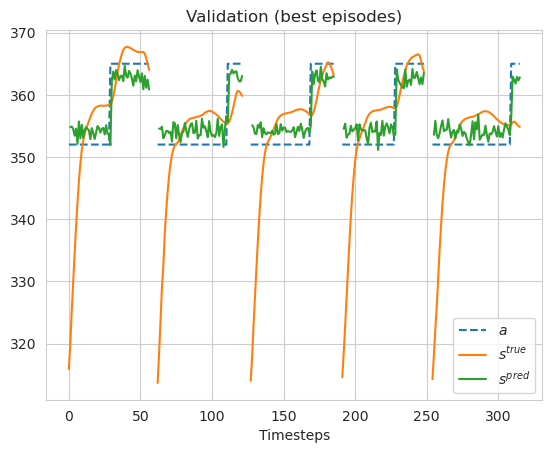

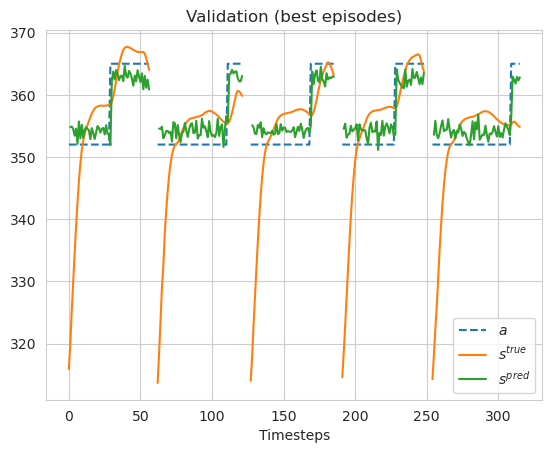

In [ ]:
rnn_h_full.plot_best_val_episodes()

In [ ]:
print(dir(rnn_h_full))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_input_to_qc', '_angle_encoding', '_binary_encoding', '_build_episode_circuit', '_fit', '_get_all_episode_features', '_get_circuit_measurements', '_get_input_t', '_get_step_features', '_init_logging', '_init_t_inputs', '_judge_train', '_judge_val', '_log_results', '_plot_features', '_plot_prediction', '_policy', '_predict', '_set_data_dims', '_set_fitter', '_set_unitary', '_set_unitary_and_meas', '_step_meas_to_step_features', '_step_meas_to_step_features_sv', '_t_input_to_t_features', 'add_x_as_feature', 'add_y_to_input', 'axis', 'backend', 'cbits_final_meas', 'corr_train', 'corr_val', 'data', 'delete_future_y', 'delete_last_

In [ ]:
rnn_h_full.qmeas

[0]

In [ ]:
rnn_h_full.weights.coef_.shape

(1, 28)

In [ ]:
IQMFakeApollo().options

In [ ]:
module_path = os.path.abspath(os.path.join('..')) 
savefile = module_path + f"/experiments/results/rewinding_rc.parquet"
df = pd.read_parquet(savefile)

In [ ]:
Indices=['corr_train', 'corr_val', 'mse_train', 'mse_val', 'mape_train',
        'mape_val', 'nrmse_train', 'nrmse_val', 'traintime', 'nenccopies',
        'ising_random', 'xyoffset', 'add_x_as_feature', 'enctype',
        'ising_jpositive', 'sim_method', 'sim_precision', 'resetm', 'ftype',
        'fitter', 'nmeas', 'qctype', 'ising_wpositive', 'restarting',
        'regression_model', 'reset_instead_meas', 'delete_future_y',
        'poly_degree', 'encangle', 'ising_wmax', 'nqubits', 'washout', 'qinit',
        'ising_h', 'ising_t', 'nyfuture', 'preloading', 'regression_alpha',
        'use_true_y_in_val', 'use_partial_meas', 'nlayers', 'ising_jmax',
        'lookback', 'regression_l1', 'add_y_to_input', 'reseti', 'mend', 't1',
        'sim', 'mtype', 'measaxes', 'set_past_y_to_0', 'encaxes',
        'lookback_max', 'log', 'minc', 'shots', 'rseed', 'nepisodes',
        'nvalepisodes', 'xtype', 'ytype', 'steps', 'memory', 'dimx', 'dimy',
        'xnorm', 'ynorm', 'rseed_data', 'train_equal_val', 'date']

for i in Indices:
    print(df[i])

0    0.846842
Name: corr_train, dtype: float64
0    0.827209
Name: corr_val, dtype: float64
0    24.701477
Name: mse_train, dtype: float64
0    25.482951
Name: mse_val, dtype: float64
0    1.06322
Name: mape_train, dtype: float64
0    1.088415
Name: mape_val, dtype: float64
0    0.013854
Name: nrmse_train, dtype: float64
0    0.014137
Name: nrmse_val, dtype: float64
0    6211
Name: traintime, dtype: int64
0    1
Name: nenccopies, dtype: int64
0    True
Name: ising_random, dtype: bool
0    1
Name: xyoffset, dtype: int64
0    True
Name: add_x_as_feature, dtype: bool
0    angle
Name: enctype, dtype: object
0    False
Name: ising_jpositive, dtype: bool
0    statevector
Name: sim_method, dtype: object
0    single
Name: sim_precision, dtype: object
0    True
Name: resetm, dtype: bool
0    0
Name: ftype, dtype: int64
0    sklearn
Name: fitter, dtype: object
0    1
Name: nmeas, dtype: int64
0    ising_hadamard
Name: qctype, dtype: object
0    False
Name: ising_wpositive, dtype: bool
0    False

In [ ]:
Indices[2]

'mse_train'

In [ ]:

df['corr_train']
df['corr_val']
df['mse_train']

0    24.701477
Name: mse_train, dtype: float64

In [ ]:
df

,corr_train,corr_val,mse_train,mse_val,mape_train,mape_val,nrmse_train,nrmse_val,traintime,nenccopies,...,ytype,steps,memory,dimx,dimy,xnorm,ynorm,rseed_data,train_equal_val,date
0,0.846842,0.827209,24.701477,25.482951,1.06322,1.088415,0.013854,0.014137,6211,1,...,treactor,80,0,1,1,norm,norm,9369,False,20240125


In [ ]:
rnn_h_full.savefile

'/home/thomascope/Python_Proj/Experiment/experiments/results/rewinding_rc.parquet'

In [ ]:
# However, this should be possible:
from iqm.qiskit_iqm import IQMFakeApollo
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':3, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':IQMFakeApollo(), 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Fake_Apollo_2nmeas'

}

fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_h_full_2 = QRewindingRC_Try_2(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h_full_2.run(data)
rnn_h_full_2.unistep.draw()

IQM


┌───┐                                                          »
q_0: ┤ H ├─■─────────────■──────────────■───────────────────────────»
     ├───┤ │ZZ(0.27392)  │              │                           »
q_1: ┤ H ├─■─────────────┼──────────────┼──────────────■────────────»
     ├───┤               │ZZ(-0.46043)  │              │ZZ(0.82551) »
q_2: ┤ H ├───────────────■──────────────┼──────────────■────────────»
     ├───┤                              │ZZ(-0.91805)               »
q_3: ┤ H ├──────────────────────────────■───────────────────────────»
     ├───┤                                                          »
q_4: ┤ H ├──────────────────────────────────────────────────────────»
     └───┘                                                          »
«                    ┌────────────┐    ┌───┐                                 »
«q_0: ─■─────────────┤ Rx(6.3654) ├────┤ H ├─────────────────────────────────»
«      │             └────────────┘    └───┘     ┌────────────┐    ┌───┐     »
«q_1: ─┼──────────────■─────────────■────────────┤ Rx(0.9725) ├────┤ H ├─────»
«      │              │             │            └────────────┘    └───┘     »
«q_2: ─┼──────────────┼─────────────┼─────────────■─────────────■────────────»
«      │              │ZZ(0.21327)  │             │ZZ(0.87014)  │            »
«q_3: ─┼──────────────■─────────────┼─────────────■─────────────┼────────────»
«      │ZZ(-0.96694)                │ZZ(0.45899)                │ZZ(0.63171) »
«q_4: ─■────────────────────────────■───────────────────────────■────────────»
«                                                                            »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«     ┌─────────────┐     ┌───┐          
«q_2: ┤ Rx(-9.8452) ├─────┤ H ├──────────
«     └─────────────┘┌────┴───┴────┐┌───┐
«q_3: ──■────────────┤ Rx(-9.2283) ├┤ H ├
«       │ZZ(0.71481) └┬────────────┤├───┤
«q_4: ──■─────────────┤ Rx(4.6931) ├┤ H ├
«                     └────────────┘└───┘

In [ ]:
rnn_h_full_2.weights.coef_.shape


(1, 40)

In [ ]:
#137 -> 1192

In [ ]:
rnn_h_full_2.qmeas

NameError: name 'rnn_h_full_2' is not defined

In [ ]:
## Let us try with the new code...

# However, this should be possible:
from iqm.qiskit_iqm import IQMFakeApollo
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':3, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':IQMFakeApollo(), 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Fake_Apollo_2nmeas'

}

fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_h_full_2 = QRewindingRC_Try_2(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h_full_2.run(data)
rnn_h_full_2.unistep.draw()

IQM


┌───┐                                                          »
q_0: ┤ H ├─■─────────────■──────────────■───────────────────────────»
     ├───┤ │ZZ(0.27392)  │              │                           »
q_1: ┤ H ├─■─────────────┼──────────────┼──────────────■────────────»
     ├───┤               │ZZ(-0.46043)  │              │ZZ(0.82551) »
q_2: ┤ H ├───────────────■──────────────┼──────────────■────────────»
     ├───┤                              │ZZ(-0.91805)               »
q_3: ┤ H ├──────────────────────────────■───────────────────────────»
     ├───┤                                                          »
q_4: ┤ H ├──────────────────────────────────────────────────────────»
     └───┘                                                          »
«                    ┌────────────┐    ┌───┐                                 »
«q_0: ─■─────────────┤ Rx(6.3654) ├────┤ H ├─────────────────────────────────»
«      │             └────────────┘    └───┘     ┌────────────┐    ┌───┐     »
«q_1: ─┼──────────────■─────────────■────────────┤ Rx(0.9725) ├────┤ H ├─────»
«      │              │             │            └────────────┘    └───┘     »
«q_2: ─┼──────────────┼─────────────┼─────────────■─────────────■────────────»
«      │              │ZZ(0.21327)  │             │ZZ(0.87014)  │            »
«q_3: ─┼──────────────■─────────────┼─────────────■─────────────┼────────────»
«      │ZZ(-0.96694)                │ZZ(0.45899)                │ZZ(0.63171) »
«q_4: ─■────────────────────────────■───────────────────────────■────────────»
«                                                                            »
«                                        
«q_0: ───────────────────────────────────
«                                        
«q_1: ───────────────────────────────────
«     ┌─────────────┐     ┌───┐          
«q_2: ┤ Rx(-9.8452) ├─────┤ H ├──────────
«     └─────────────┘┌────┴───┴────┐┌───┐
«q_3: ──■────────────┤ Rx(-9.2283) ├┤ H ├
«       │ZZ(0.71481) └┬────────────┤├───┤
«q_4: ──■─────────────┤ Rx(4.6931) ├┤ H ├
«                     └────────────┘└───┘

In [ ]:
rnn_h_full_2.qc.draw()

┌────┐     ┌────┐           ┌────┐┌───┐        ┌─┐         »
q_0: ──────────────┤0   ├─────┤0   ├───────────┤0   ├┤ H ├────────┤M├─────────»
                   │    │     │    │           │    │├───┤        └╥┘┌─┐      »
q_1: ──────────────┤1   ├─────┤1   ├───────────┤1   ├┤ H ├─────────╫─┤M├──────»
                   │    │     │    │           │    │├───┤         ║ └╥┘┌─┐   »
q_2: ──────────────┤2 U ├─────┤2   ├───────────┤2   ├┤ H ├─────────╫──╫─┤M├───»
      ┌──────────┐ │    │┌───┐│    │┌─┐        │    │└───┘         ║  ║ └╥┘   »
q_3: ─┤ Rx(4π/5) ├─┤3   ├┤ H ├┤  U ├┤M├────────┤    ├──────────────╫──╫──╫────»
     ┌┴──────────┴┐│    │├───┤│    │└╥┘┌─┐     │    │              ║  ║  ║    »
q_4: ┤ Rx(1.2541) ├┤4   ├┤ H ├┤    ├─╫─┤M├─────┤  U ├──────────────╫──╫──╫────»
     └┬──────────┬┘└────┘└───┘│    │ ║ └╥┘┌───┐│    │ ┌─┐          ║  ║  ║    »
q_5: ─┤ Rx(4π/5) ├────────────┤3   ├─╫──╫─┤ H ├┤    ├─┤M├──────────╫──╫──╫────»
     ┌┴──────────┴┐           │    │ ║  ║ ├───┤│    │ └╥┘ ┌─┐      ║  ║  ║    »
q_6: ┤ Rx(1.2838) ├───────────┤4   ├─╫──╫─┤ H ├┤    ├──╫──┤M├──────╫──╫──╫────»
     └┬──────────┬┘           └────┘ ║  ║ └───┘│    │  ║  └╥┘┌───┐ ║  ║  ║ ┌─┐»
q_7: ─┤ Rx(4π/5) ├───────────────────╫──╫──────┤3   ├──╫───╫─┤ H ├─╫──╫──╫─┤M├»
     ┌┴──────────┴┐                  ║  ║      │    │  ║   ║ ├───┤ ║  ║  ║ └╥┘»
q_8: ┤ Rx(1.3828) ├──────────────────╫──╫──────┤4   ├──╫───╫─┤ H ├─╫──╫──╫──╫─»
     └────────────┘                  ║  ║      └────┘  ║   ║ └───┘ ║  ║  ║  ║ »
c: 9/════════════════════════════════╩══╩══════════════╩═══╩═══════╩══╩══╩══╩═»
                                     3  4              5   6       0  1  2  7 »
«        
«q_0: ───
«        
«q_1: ───
«        
«q_2: ───
«        
«q_3: ───
«        
«q_4: ───
«        
«q_5: ───
«        
«q_6: ───
«        
«q_7: ───
«     ┌─┐
«q_8: ┤M├
«     └╥┘
«c: 9/═╩═
«      8

MSE per episode
 [[  9.          13.40916108]
 [ 13.          24.86284099]
 [  7.          26.42846948]
 [ 10.          29.34483858]
 [  8.          29.5480356 ]
 [  6.          33.44107669]
 [ 11.          33.81417645]
 [ 12.          36.05373208]
 [  4.          38.45978841]
 [  2.          40.76833125]
 [  0.          53.35112476]
 [  5.          61.14873478]
 [  1.          76.56804067]
 [  3.          82.7515971 ]
 [ 14.         110.08853796]]


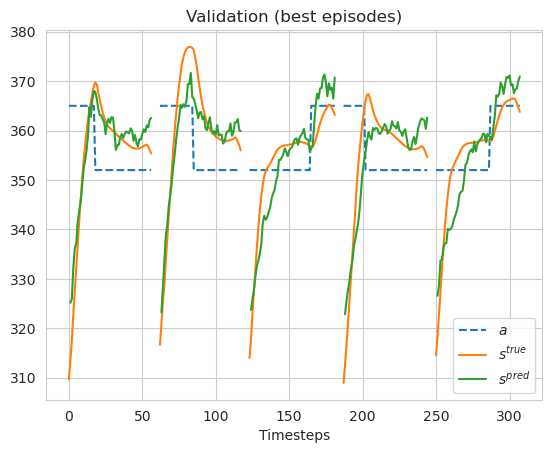

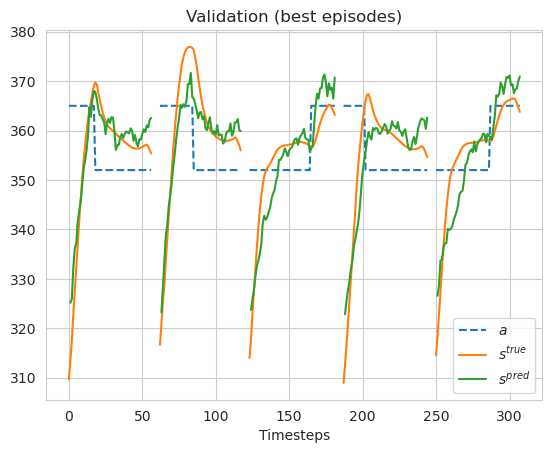

In [ ]:
rnn_h_full_2.plot_best_val_episodes()

In [ ]:
IQMFakeApollo().__dict__

{'_options': Options(shots=1024, calibration_set_id=None),
 '_provider': None,
 'name': 'IQMFakeApolloBackend',
 'description': None,
 'online_date': None,
 'backend_version': None,
 '_coupling_map': None,
 '_target': <qiskit.transpiler.target.Target at 0x7f53a27b9380>,
 '_qb_to_idx': {'QB1': 0,
  'QB2': 1,
  'QB3': 2,
  'QB4': 3,
  'QB5': 4,
  'QB6': 5,
  'QB7': 6,
  'QB8': 7,
  'QB9': 8,
  'QB10': 9,
  'QB11': 10,
  'QB12': 11,
  'QB13': 12,
  'QB14': 13,
  'QB15': 14,
  'QB16': 15,
  'QB17': 16,
  'QB18': 17,
  'QB19': 18,
  'QB20': 19},
 '_idx_to_qb': {0: 'QB1',
  1: 'QB2',
  2: 'QB3',
  3: 'QB4',
  4: 'QB5',
  5: 'QB6',
  6: 'QB7',
  7: 'QB8',
  8: 'QB9',
  9: 'QB10',
  10: 'QB11',
  11: 'QB12',
  12: 'QB13',
  13: 'QB14',
  14: 'QB15',
  15: 'QB16',
  16: 'QB17',
  17: 'QB18',
  18: 'QB19',
  19: 'QB20'},
 '_quantum_architecture': QuantumArchitectureSpecification(name='Apollo', operations=['phased_rx', 'cz', 'measurement', 'barrier'], qubits=['QB1', 'QB2', 'QB3', 'QB4', 'QB5', 'Q

In [ ]:
IQMFakeApollo().__dict__.keys()

dict_keys(['_options', '_provider', 'name', 'description', 'online_date', 'backend_version', '_coupling_map', '_target', '_qb_to_idx', '_idx_to_qb', '_quantum_architecture', '_IQMFakeBackend__architecture', '_IQMFakeBackend__error_profile', 'noise_model'])

In [ ]:
iqm_server_url = "https://cpq20-host1.cpq20.iqm.fi/cocos"
calset = "70ed8068-c9ef-40c1-8095-acc4d3d95619"

provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()

In [ ]:
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':8, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Real_Apollo'

}

fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_real = QRewindingRC_Try_2(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_real.run(data)

IQM


APITimeoutError: The job didn't finish in 900 seconds.

In [ ]:
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':8, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Real_Apollo_poly_fit'
                            

}

fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_poly_fit = QRewindingRC_Try_2(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_poly_fit.run(data)

NameError: name 'backend' is not defined

In [ ]:
iqm_server_url = "https://cpq20-host1.cpq20.iqm.fi/cocos"
calset = "70ed8068-c9ef-40c1-8095-acc4d3d95619"

provider = IQMProvider(iqm_server_url)
backend = provider.get_backend()

Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':8, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Real_Apollo_Batched',
                              'max_batch': 4500, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'calibration_set_id' : "70ed8068-c9ef-40c1-8095-acc4d3d95619",
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_batch = QRewindingRC_Batch(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_batch.run(data)

IQM
You have specified  19 qubits required. Correct?
Dealing with 597 circuits, 4.289e+05 instructions, and 4.891e+06 total shots.
Created 100 batches!
Optimistic and approximate runtime: 5790.624 seconds
An error occured: retry! The job didn't finish in 900 seconds.
An error occured: retry! The job didn't finish in 900 seconds.
An error occured: retry! The job didn't finish in 900 seconds.


KeyboardInterrupt: 

In [19]:
rnn_batch

NameError: name 'rnn_batch' is not defined

In [ ]:
rnn_batch.qubits

['QB1',
 'QB2',
 'QB3',
 'QB4',
 'QB5',
 'QB6',
 'QB7',
 'QB8',
 'QB9',
 'QB10',
 'QB11',
 'QB12',
 'QB13',
 'QB14',
 'QB15',
 'QB16',
 'QB17',
 'QB18',
 'QB19',
 'QB20']

In [ ]:
rnn_batch.reduced_coupling_map
rnn_batch.backend.coupling_map

In [ ]:
#rnn_batch.backend.coupling_map.make_symmetric()
#[list(edge) for edge in rnn_batch.backend.coupling_map if set(edge).issubset(set(rnn_batch.qubits))]
rnn_batch.qc_list[-1]._data[-20:]

[CircuitInstruction(operation=Instruction(name='barrier', num_qubits=19, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(20, 'q'), 12), Qubit(QuantumRegister(20, 'q'), 8), Qubit(QuantumRegister(20, 'q'), 13), Qubit(QuantumRegister(20, 'q'), 7), Qubit(QuantumRegister(20, 'q'), 17), Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 6), Qubit(QuantumRegister(20, 'q'), 11), Qubit(QuantumRegister(20, 'q'), 16), Qubit(QuantumRegister(20, 'q'), 2), Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 10), Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 14), Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 9)), clbits=()),
 CircuitInstruction(operation=Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), qubits=(Qubit(QuantumRegister(20, 'q'), 12),), clbits=(Clbit(ClassicalRegister(19, 'c'), 

In [ ]:
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
len(data.xval)

15

In [ ]:
rnn_batch.initial_layout

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
max([len(x) for x in data.xval])

88

In [ ]:
for e,b in enumerate('zyx'[:3]):
    print(e,b)

0 z
1 y
2 x


In [ ]:
3*15*88

3960

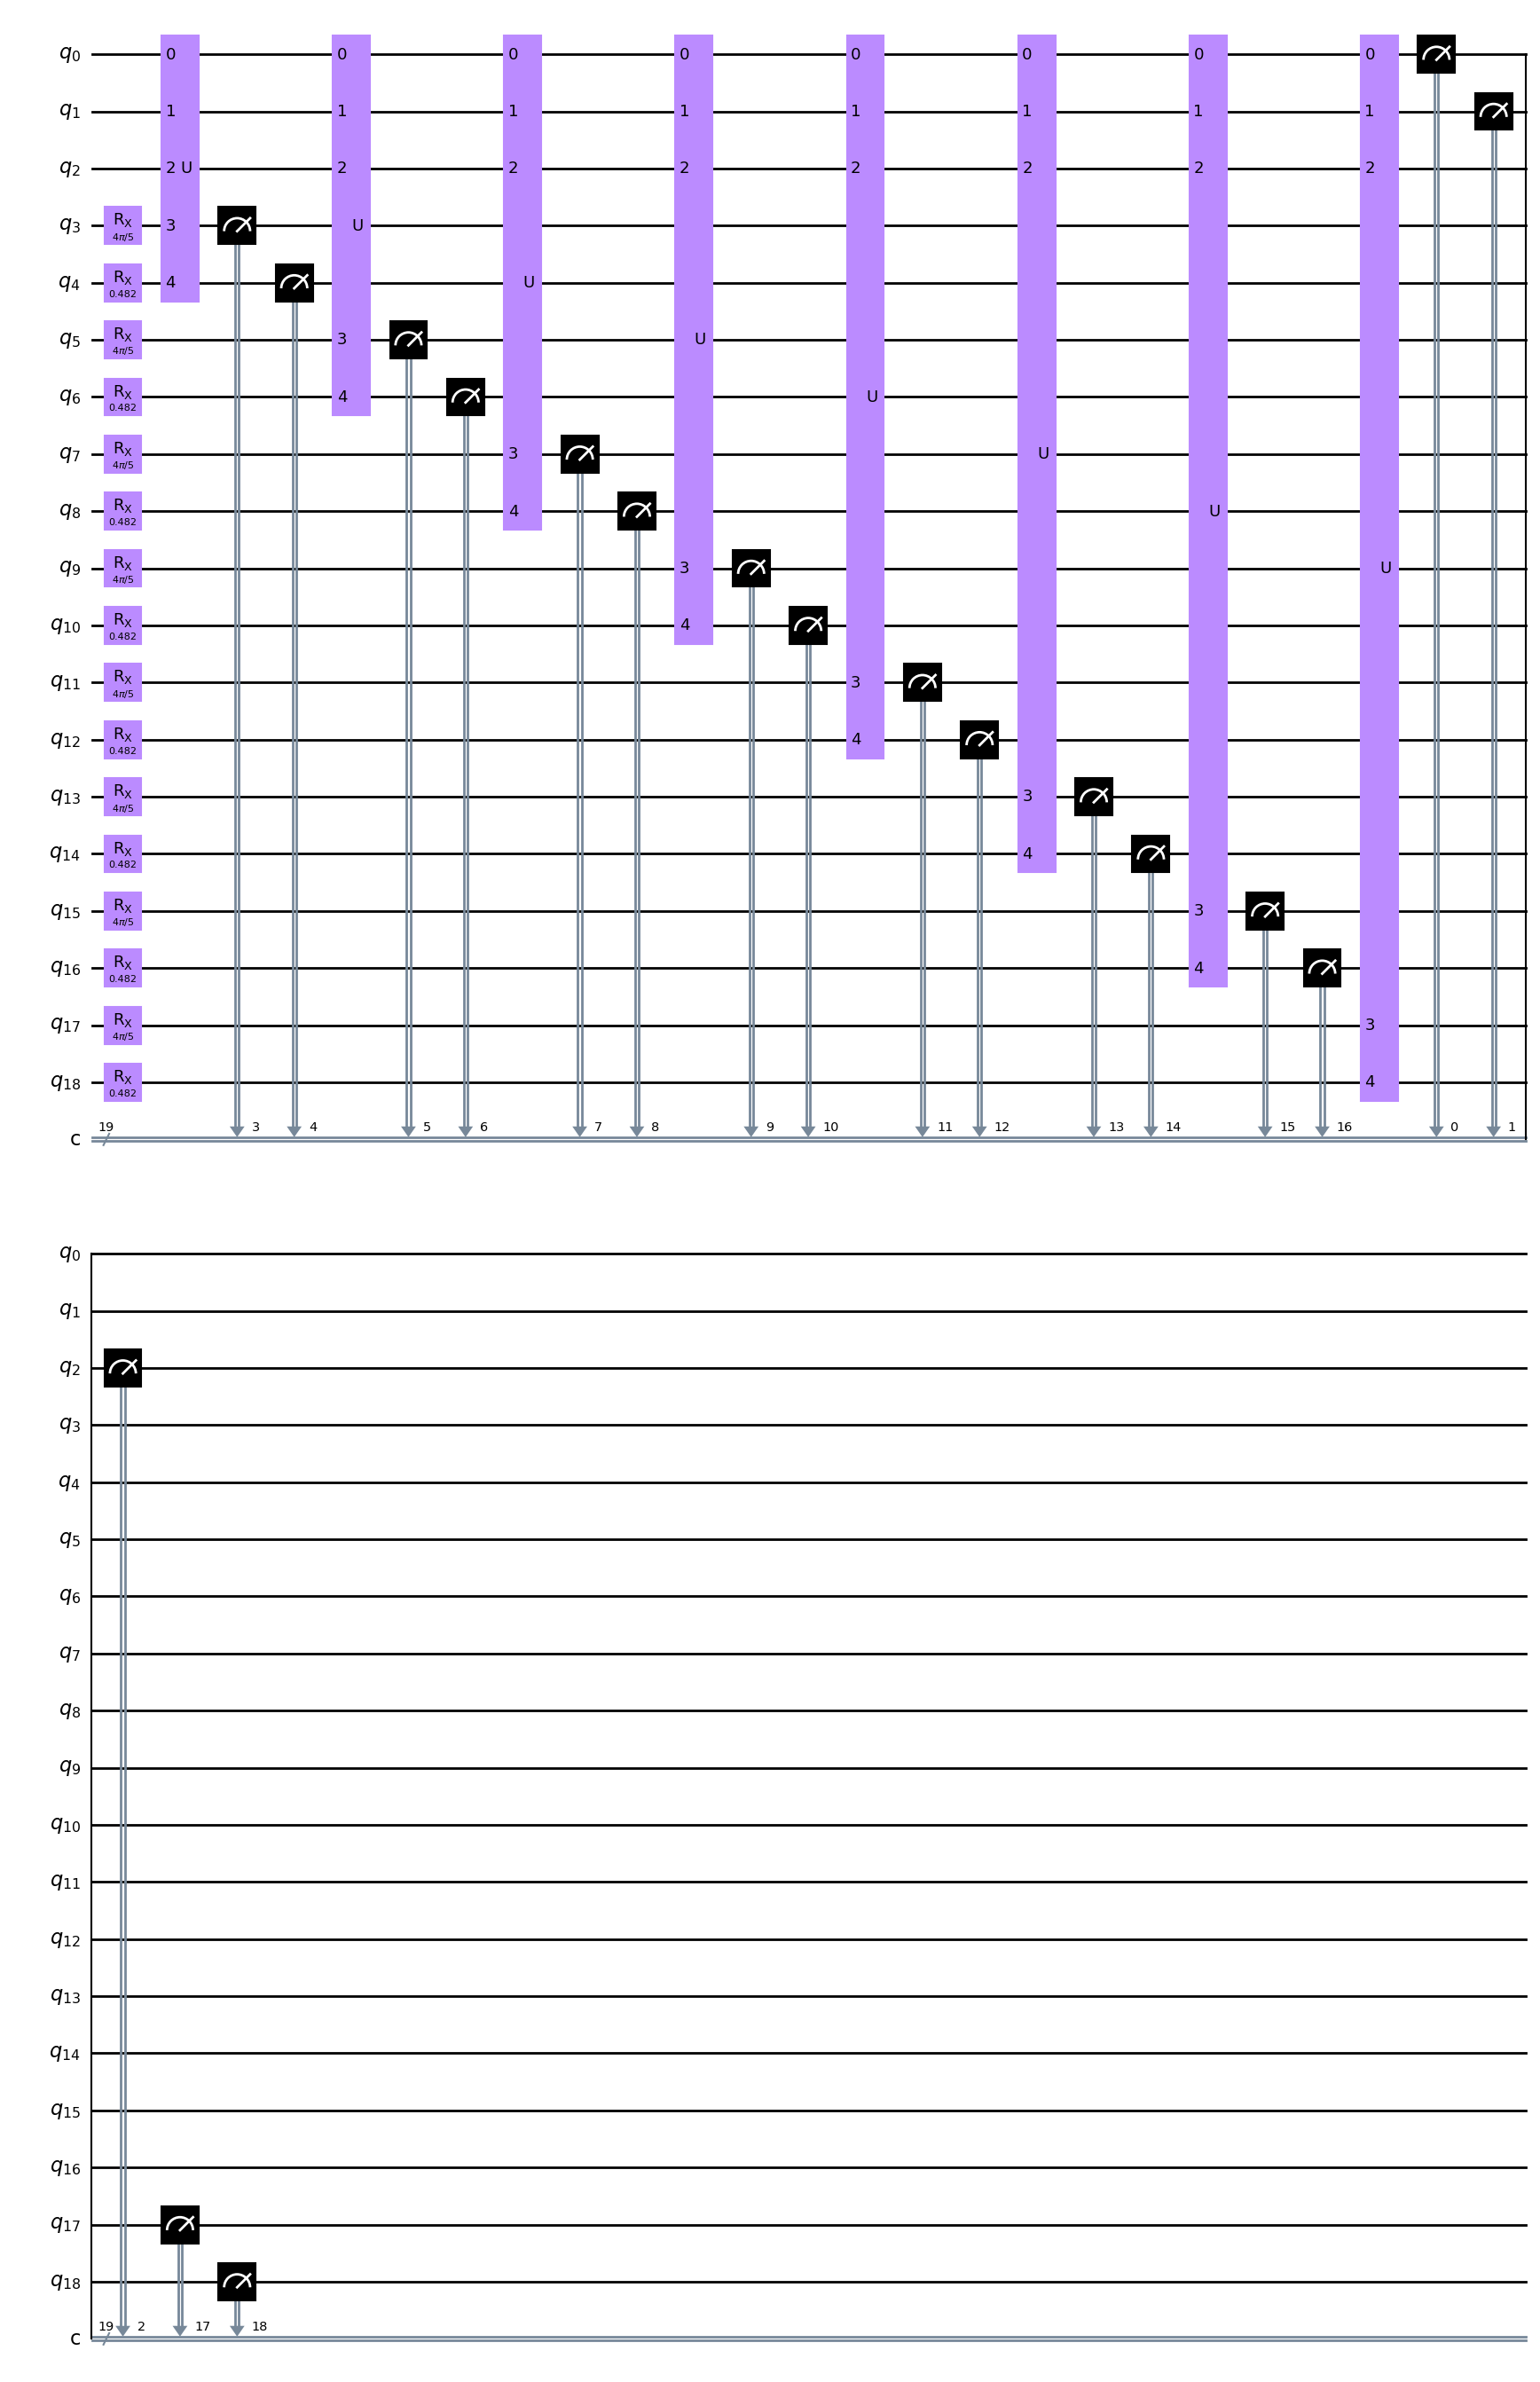

In [ ]:
rnn_batch.pre_trans[0].draw('mpl')

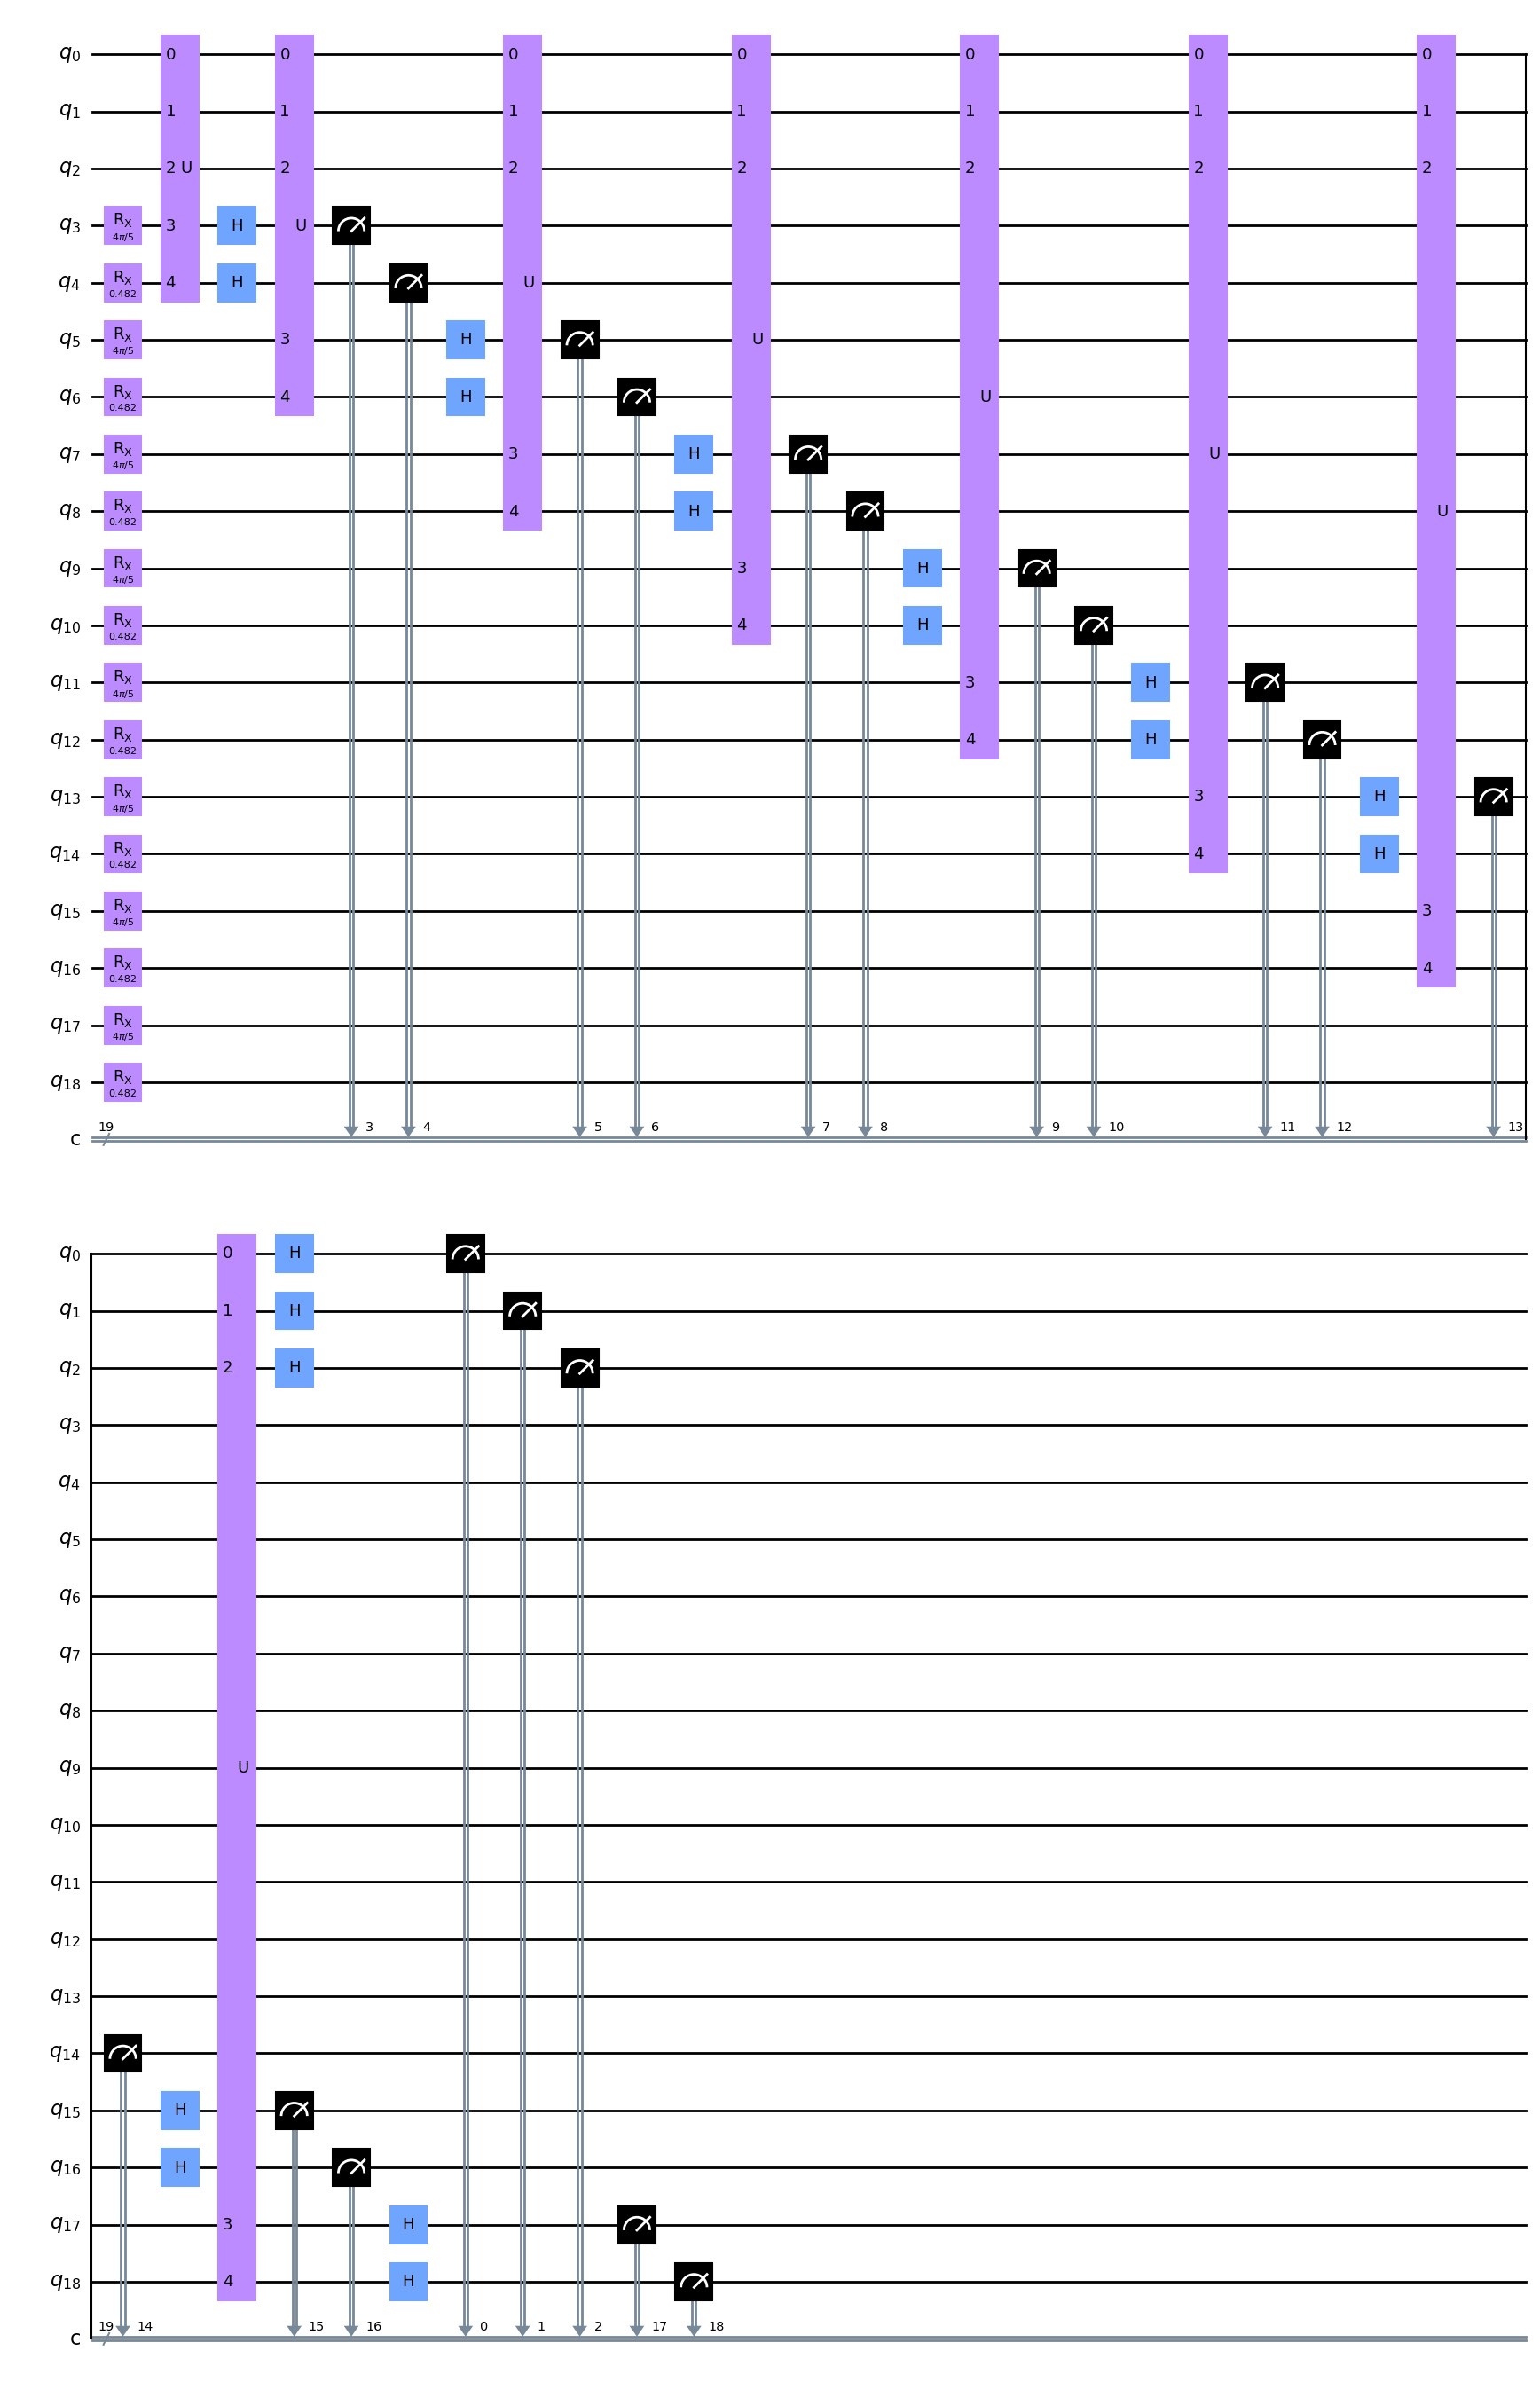

In [ ]:
rnn_batch.pre_trans[-1].draw('mpl')

In [23]:

# However, this should be possible:
from iqm.qiskit_iqm import IQMFakeApollo
Free_Experimental_Parameters={'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':2, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':True, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn', # set to sklearn_poly for higher order fits.
                                'regression_model':'regression', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits.
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':IQMFakeApollo(), 
                              't1':50, 
                              'sim_method':'statevector',
                              'sim_precision':'double',
                              'file_name':'Fake_Apollo_2nmeas'

}

fulldict = Set_Experimental_Parameters | Free_Experimental_Parameters

# By contrast, we here are trying to run a full simulation of an 11 qubit circuit. Fake Apollo is 20 qubits, so should work...
rnn_h_full_2 = QRewindingRC_Single_Use_QPU(**fulldict)
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
rnn_h_full_2.run(data)
rnn_h_full_2.unistep.draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit_natural.svg',
    # scale=0.5,
    style='bw', # iqx bw
)

IQM


KeyboardInterrupt: 

In [27]:
len(rnn_h_full_2.data.xtrain)

40

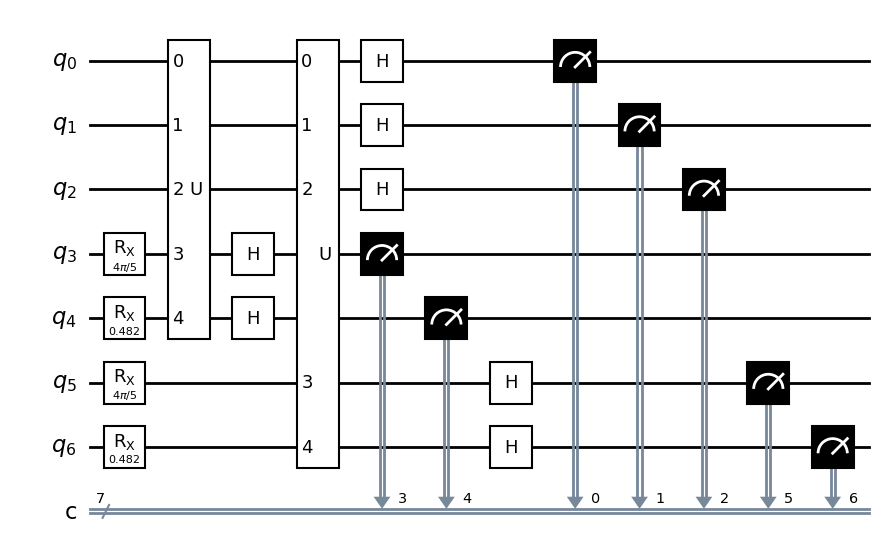

In [ ]:
rnn_h_full_2.qc.draw(
    output='mpl',
    filename=f'{fig_path}/ising_circuit_natural.svg',
    # scale=0.5,
    style='bw', # iqx bw
)